In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd drive
%cd 'My Drive'
%cd 'IS projects'
%cd Homework3
%cd DataSet2

/content/drive
/content/drive/My Drive
/content/drive/My Drive/IS projects
/content/drive/My Drive/IS projects/Homework3
/content/drive/My Drive/IS projects/Homework3/DataSet2


In [3]:
import pandas as pd
import random
import numpy as np
from matplotlib import pyplot as plt

WEIGHT = 1
BIAS = 0 
ALPHA = 0.1
DUMMY = 1e-1

#### Read data

In [4]:
def read_data(filename): return pd.read_csv(filename, index_col = None, header = None).to_numpy()

#### Normalize data

In [5]:
def rescale_data(data): return (data - np.min(data))/(np.max(data) - np.min(data))

#### Reshape to 3D

In [6]:
def reshape_data(data): return data.reshape(data.shape[0], 1, data.shape[1])

#### One-Hot coding labels

In [7]:
def to_categorical(data):
  data = data.flatten()
  coded_data = np.zeros((data.max()+1, data.size))
  coded_data[data, np.arange(data.size)] = 1
  return coded_data

In [8]:
def preprocess(data):
  rescaled = np.array([rescale_data(data[k]) for k in range(len(data))])
  return reshape_data(rescaled)

#### ReLu activation function

In [9]:
def relu(x): return np.maximum(0, x)
def relu_prime(x): return 1*(x >= 0)

#### tanh activation function

In [ ]:
def tanh(x): return np.tanh(x)
def tanh_prime(x) : return 1 - np.power(np.tanh(x), 2)

#### MSE as cost function

In [10]:
def MSE_calculator(true_value, errored_value): return np.mean(np.power(true_value- errored_value, 2))
def MSE_prime_calculator(true_value, errored_value): return 2*(errored_value - true_value)/true_value.size

#### Calculating accuracy using argmax

In [11]:
def caculate_accuracy(network, datas, labels): return sum([np.argmax(label) == np.argmax(network.predict(data)) for data, label in zip(datas, labels)]) / (0.01*len(datas))

#### HiddenLayer class with weight and bias as attributes and forward and bakckward propagation methods

In [12]:
class HiddenLayer:
  def __init__(self, input_size, output_size):
    self.input = None
    self.output = None
    self.weights = np.random.rand(input_size, output_size)/ input_size
    self.biases = np.random.rand(1, output_size) - 0.5

  def update_parameters(self, errors):
    self.weights, self.biases = self.weights  - ALPHA*errors[WEIGHT], self.biases  - ALPHA*errors[BIAS]
  
  def forward_propagation(self, input_data):
    self.input = input_data
    self.output = np.dot(self.input, self.weights) + self.biases
    return self.output

  def backward_propagation(self, output_error):
    input_error, weights_error = np.dot(output_error, self.weights.T), np.dot(self.input.T, output_error)
    self.update_parameters([output_error, weights_error])
    return input_error

#### ActivationFunction class with activation and derivitive of activation as attributes and forward and bakckward propagation methods

In [13]:
class ActivationFunction:
  def __init__(self, _activation, _activation_prime):
    self.input = None
    self.output = None
    self.activation = _activation
    self.activation_prime = _activation_prime

  def forward_propagation(self, input_data):
    self.input = input_data
    self.output = self.activation(self.input)
    return self.output

  def backward_propagation(self, output_error): return self.activation_prime(self.input)*output_error
    

#### The main class - NeuralNerwork with loss and it's derivitive as attributes and train and predict as methods

In [14]:
class NeuralNerwork:
    def __init__(self):
        self.layers = []
        self.loss = None
        self.loss_prime = None

    def add_layer(self, layer): self.layers.append(layer)

    def set_loss_parameters(self, loss, loss_prime):
        self.loss,  self.loss_prime = loss, loss_prime

    def predict(self, input_data):
      output = input_data
      for layer in self.layers:
        output = layer.forward_propagation(output)
      return output

    def loaded_predict(self, input_data, loaded_data):
      layer[0].weights = loaded_data[0]
      layer[2].weights = loaded_data[1]
      output = input_data
      for layer in self.layers:
         output = layer.forward_propagation(output)
      return output

    def train(self, train_data, train_labels):
        epochs = 50
        accuracy_per_epoch, val_accuracy_per_epoch, error_per_epoch, val_error_per_epoch = [], [], [], []
        for epoch in range(epochs):
          error, val_error = 0, 0
          for k in range(len(train_data)):
            output = train_data[k]
            for layer in self.layers:
                output = layer.forward_propagation(output)
            error += self.loss(train_labels[k], output)
            #val_error +=self.loss(train_labels[k], output)
            backward_error = self.loss_prime(train_labels[k], output)
            for layer in reversed(self.layers):
              backward_error = layer.backward_propagation(backward_error)
          val_accuracy_per_epoch.append(caculate_accuracy(self, test_data, test_labels.T))
          accuracy_per_epoch.append(caculate_accuracy(self, train_data, train_labels))
          error_per_epoch.append(error/len(train_data))
          val_error_per_epoch.append(DUMMY)
          print('epoch %d/%d \t error = %f \t test accuracy = %f \t  train accuracy = %f ' %(epoch+1, epochs, error/len(train_data), val_accuracy_per_epoch[-1],  accuracy_per_epoch[-1]))
          accuracies = [val_accuracy_per_epoch, accuracy_per_epoch]
          errors = [val_error_per_epoch, error_per_epoch]
        return accuracies, errors

#### plot accuracy and loss

In [15]:
def plot_network_accuracy(history):
  plt.plot(history[0][0],color = 'steelblue' )
  plt.annotate('%' + str(round(history[0][0][-1],3)), xy=(len(history[0][0])-2, history[0][0][-1]), xytext=(len(history[0][0])-2, history[0][0][-1]), color = 'steelblue')
  plt.plot(history[0][1], color = 'pink')
  plt.annotate('%' + str(np.round(history[0][1][-1],3)), xy=(len(history[0][0])-2, history[0][1][-1]), xytext=(len(history[0][0])-2, history[0][1][-1]), color = 'pink' )
  plt.title('Network Accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['validation accuracy', 'train accuracy'], loc='upper left')
  plt.show()

  # plt.plot(history[1][0],color = 'lightskyblue' )
  # plt.annotate( str(round(history[1][0][-1],3)), xy=(len(history[0][0])-2, history[1][0][-1]), xytext=(len(history[0][0])-2, history[1][0][-1]), color = 'steelblue')
  # plt.plot(history[1][1], color = 'lightpink')
  # plt.annotate( str(np.round(history[1][1][-1],3)), xy=(len(history[0][0])-2, history[1][1][-1]), xytext=(len(history[0][0])-2, history[1][1][-1]), color = 'pink' )
  # plt.title('Network loss')
  # plt.ylabel('loss')
  # plt.xlabel('epoch')
  # plt.legend(['validation loss', 'train loss'], loc='upper left')
  # plt.show()

#### save weights

In [ ]:
def save_weight(path, neuralnet): np.savetxt(path, neuralnet.layers[0].weights)

#### load weights

In [ ]:
def load_weight(path): return np.loadtxt(path)

### read data from Dataset

In [16]:
x_train = read_data('Reduced_Train_Data.csv')
x_test = read_data('Reduced_Test_Data.csv')
y_train = read_data('trainLabels.csv')
y_test = read_data('testLabels.csv')

In [17]:
train_data = preprocess(x_train)
test_data = preprocess(x_test)

In [18]:
train_labels = to_categorical(y_train)
test_labels = to_categorical(y_test)

#### Making a neural network with 150 hidden nodes and tanh as activation function

In [ ]:
neuralnet = NeuralNerwork()
neuralnet.add_layer(HiddenLayer(128, 150))                
neuralnet.add_layer(ActivationFunction(tanh, tanh_prime))
neuralnet.add_layer(HiddenLayer(150, 10))                    
neuralnet.add_layer(ActivationFunction(tanh, tanh_prime))

neuralnet.set_loss_parameters(MSE_calculator, MSE_prime_calculator)
accuracies, errors = neuralnet.train(train_data, train_labels.T)

epoch 1/50 	 error = 0.056588 	 test accuracy = 75.490000 	  train accuracy = 76.375000 
epoch 2/50 	 error = 0.045770 	 test accuracy = 78.410000 	  train accuracy = 79.456667 
epoch 3/50 	 error = 0.043719 	 test accuracy = 79.030000 	  train accuracy = 79.908333 
epoch 4/50 	 error = 0.042805 	 test accuracy = 79.150000 	  train accuracy = 80.050000 
epoch 5/50 	 error = 0.042276 	 test accuracy = 79.210000 	  train accuracy = 80.120000 
epoch 6/50 	 error = 0.041908 	 test accuracy = 79.210000 	  train accuracy = 80.128333 
epoch 7/50 	 error = 0.041621 	 test accuracy = 79.200000 	  train accuracy = 80.176667 
epoch 8/50 	 error = 0.041389 	 test accuracy = 79.230000 	  train accuracy = 80.223333 
epoch 9/50 	 error = 0.041195 	 test accuracy = 79.230000 	  train accuracy = 80.271667 
epoch 10/50 	 error = 0.040968 	 test accuracy = 79.150000 	  train accuracy = 80.250000 
epoch 11/50 	 error = 0.040678 	 test accuracy = 79.210000 	  train accuracy = 80.253333 
epoch 12/50 	 error

Loss of Neural Network with 150 nodes in hidden layer and tanh as activation function for validation data is: 0.03
Accuracy of Neural Network with 150 nodes in hidden layerand tanh as activation function for validation data is: % 81.90


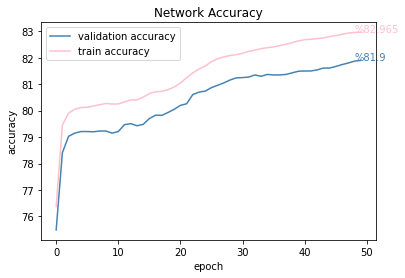

In [ ]:
print('Loss of Neural Network with 150 nodes in hidden layer and tanh as activation function for validation data is: %1.2f' %errors[1][-1])
print('Accuracy of Neural Network with 150 nodes in hidden layerand tanh as activation function for validation data is: %% %1.2f' %accuracies[0][-1])
plot_network_accuracy([accuracies, errors])

#### Making a neural network with 100 hidden nodes and tanh as activation function

In [ ]:
neuralnet_100 = NeuralNerwork()
neuralnet_100.add_layer(HiddenLayer(128, 100))                
neuralnet_100.add_layer(ActivationFunction(tanh, tanh_prime))
neuralnet_100.add_layer(HiddenLayer(100, 10))                    
neuralnet_100.add_layer(ActivationFunction(tanh, tanh_prime))

neuralnet_100.set_loss_parameters(MSE_calculator, MSE_prime_calculator)
accuracies_100, errors_100 = neuralnet_100.train(train_data, train_labels.T)

epoch 1/50 	 error = 0.056620 	 test accuracy = 75.550000 	  train accuracy = 76.341667 
epoch 2/50 	 error = 0.045343 	 test accuracy = 78.430000 	  train accuracy = 79.370000 
epoch 3/50 	 error = 0.043456 	 test accuracy = 79.010000 	  train accuracy = 79.873333 
epoch 4/50 	 error = 0.042589 	 test accuracy = 79.240000 	  train accuracy = 80.075000 
epoch 5/50 	 error = 0.041968 	 test accuracy = 79.260000 	  train accuracy = 80.098333 
epoch 6/50 	 error = 0.041359 	 test accuracy = 79.270000 	  train accuracy = 80.041667 
epoch 7/50 	 error = 0.040722 	 test accuracy = 79.370000 	  train accuracy = 80.141667 
epoch 8/50 	 error = 0.040143 	 test accuracy = 79.410000 	  train accuracy = 80.265000 
epoch 9/50 	 error = 0.039662 	 test accuracy = 79.400000 	  train accuracy = 80.353333 
epoch 10/50 	 error = 0.039139 	 test accuracy = 79.620000 	  train accuracy = 80.553333 
epoch 11/50 	 error = 0.038318 	 test accuracy = 79.850000 	  train accuracy = 80.796667 
epoch 12/50 	 error

Loss of Neural Network with 100 nodes in hidden layer and tanh as activation functionfor validation data is: 0.03
Accuracy of Neural Network with 100 nodes in hidden layer and tanh as activation function for validation data is: % 82.55


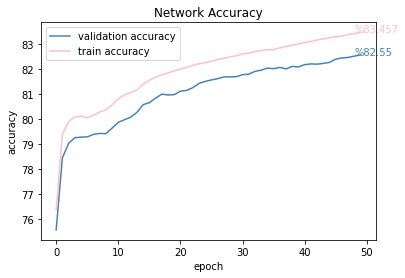

In [ ]:
print('Loss of Neural Network with 100 nodes in hidden layer and tanh as activation functionfor validation data is: %1.2f' %errors_100[1][-1])
print('Accuracy of Neural Network with 100 nodes in hidden layer and tanh as activation function for validation data is: %% %1.2f' %accuracies_100[0][-1])
plot_network_accuracy([accuracies_100, errors_100])

#### Making a neural network with 300 hidden nodes and tanh as activation function

In [ ]:
neuralnet_300 = NeuralNerwork()
neuralnet_300.add_layer(HiddenLayer(128, 300))                
neuralnet_300.add_layer(ActivationFunction(tanh, tanh_prime))
neuralnet_300.add_layer(HiddenLayer(300, 10))                    
neuralnet_300.add_layer(ActivationFunction(tanh, tanh_prime))

neuralnet_300.set_loss_parameters(MSE_calculator, MSE_prime_calculator)
accuracies_300, errors_300 = neuralnet_300.train(train_data, train_labels.T)

epoch 1/50 	 error = 0.056469 	 test accuracy = 75.660000 	  train accuracy = 76.505000 
epoch 2/50 	 error = 0.045683 	 test accuracy = 78.310000 	  train accuracy = 79.445000 
epoch 3/50 	 error = 0.044052 	 test accuracy = 78.960000 	  train accuracy = 79.816667 
epoch 4/50 	 error = 0.043354 	 test accuracy = 79.140000 	  train accuracy = 80.003333 
epoch 5/50 	 error = 0.042954 	 test accuracy = 79.260000 	  train accuracy = 80.055000 
epoch 6/50 	 error = 0.042691 	 test accuracy = 79.310000 	  train accuracy = 80.116667 
epoch 7/50 	 error = 0.042503 	 test accuracy = 79.400000 	  train accuracy = 80.150000 
epoch 8/50 	 error = 0.042345 	 test accuracy = 79.370000 	  train accuracy = 80.170000 
epoch 9/50 	 error = 0.041930 	 test accuracy = 79.330000 	  train accuracy = 80.183333 
epoch 10/50 	 error = 0.041656 	 test accuracy = 79.280000 	  train accuracy = 80.228333 
epoch 11/50 	 error = 0.041476 	 test accuracy = 79.330000 	  train accuracy = 80.261667 
epoch 12/50 	 error

Loss of Neural Network with 300 nodes in hidden layer and tanh as activation function for validation data is: 0.03
Accuracy of Neural Network with 300 nodes in hidden layer and tanh as activation function for validation data is: % 80.68


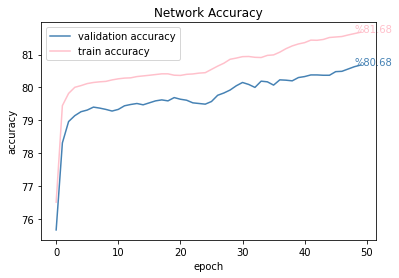

In [ ]:
print('Loss of Neural Network with 300 nodes in hidden layer and tanh as activation function for validation data is: %1.2f' %errors_300[1][-1])
print('Accuracy of Neural Network with 300 nodes in hidden layer and tanh as activation function for validation data is: %% %1.2f' %accuracies_300[0][-1])
plot_network_accuracy([accuracies_300, errors_300])

#### Making a neural network with 150 hidden nodes and ReLu as activation function

In [24]:
ALPHA = 0.1
neuralnet_relu = NeuralNerwork()
neuralnet_relu.add_layer(HiddenLayer(128, 150))                
neuralnet_relu.add_layer(ActivationFunction(relu, relu_prime))
neuralnet_relu.add_layer(HiddenLayer(150, 10))                    
neuralnet_relu.add_layer(ActivationFunction(relu, relu_prime))

neuralnet_relu.set_loss_parameters(MSE_calculator, MSE_prime_calculator)
accuracies_relu, errors_relu = neuralnet_relu.train(train_data, train_labels.T)

epoch 1/50 	 error = 0.049378 	 test accuracy = 75.700000 	  train accuracy = 76.271667 
epoch 2/50 	 error = 0.037032 	 test accuracy = 77.290000 	  train accuracy = 78.043333 
epoch 3/50 	 error = 0.034741 	 test accuracy = 77.700000 	  train accuracy = 78.485000 
epoch 4/50 	 error = 0.033515 	 test accuracy = 78.070000 	  train accuracy = 78.703333 
epoch 5/50 	 error = 0.032561 	 test accuracy = 78.310000 	  train accuracy = 78.971667 
epoch 6/50 	 error = 0.031857 	 test accuracy = 78.570000 	  train accuracy = 79.325000 
epoch 7/50 	 error = 0.031291 	 test accuracy = 78.720000 	  train accuracy = 79.443333 
epoch 8/50 	 error = 0.030716 	 test accuracy = 78.850000 	  train accuracy = 79.753333 
epoch 9/50 	 error = 0.030159 	 test accuracy = 79.050000 	  train accuracy = 79.910000 
epoch 10/50 	 error = 0.029826 	 test accuracy = 79.060000 	  train accuracy = 79.980000 
epoch 11/50 	 error = 0.029537 	 test accuracy = 79.180000 	  train accuracy = 80.043333 
epoch 12/50 	 error

Loss of Neural Network with 150 nodes in hidden layer and tanh as activation function for validation data is: 0.03
Accuracy of Neural Network with 150 nodes in hidden layer and tanh as activation function for validation data is: % 80.75


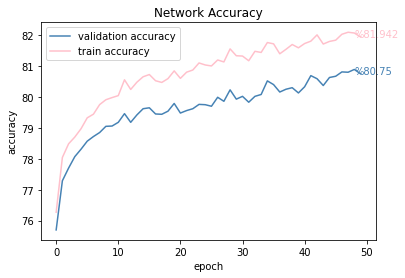

In [25]:
print('Loss of Neural Network with 150 nodes in hidden layer and tanh as activation function for validation data is: %1.2f' %errors_relu[1][-1])
print('Accuracy of Neural Network with 150 nodes in hidden layer and tanh as activation function for validation data is: %% %1.2f' %accuracies_relu[0][-1])
plot_network_accuracy([accuracies_relu, errors_relu])

In [ ]:
save_weight("HiddenLayer1_Weights.txt", neuralnet)
save_weight("HiddenLayer2_Weights.txt", neuralnet)

save_weight("HiddenLayer1_100_Weights.txt", neuralnet_100)
save_weight("HiddenLayer2_100_Weights.txt", neuralnet_100)

save_weight("HiddenLayer1_300_Weights.txt", neuralnet_300)
save_weight("HiddenLayer2_300_Weights.txt", neuralnet_300)

save_weight("HiddenLayer1_relu_Weights.txt", neuralnet_relu)
save_weight("HiddenLayer2_relu_Weights.txt", neuralnet_relu)

In [ ]:
weights1 = load_weight("HiddenLayer1_Weights.txt")
weights2 = load_weight("HiddenLayer2_Weights.txt")

# weights1 = load_weight("HiddenLayer1_100_Weights.txt")
# weights2 = load_weight("HiddenLayer2_100_Weights.txt")

# weights1 = load_weight("HiddenLayer1_300_Weights.txt")
# weights2 = load_weight("HiddenLayer2_300_Weights.txt")

# weights1 = load_weight("HiddenLayer1_relu_Weights.txt")
# weights2 = load_weight("HiddenLayer2_relu_Weights.txt")

In [ ]:
nnet = NeuralNerwork()
nnet.add_layer(HiddenLayer(128, 150))                
nnet.add_layer(ActivationFunction(tanh, tanh_prime))
nnet.add_layer(HiddenLayer(150, 10))                    
nnet.add_layer(ActivationFunction(tanh, tanh_prime))

nnet.set_loss_parameters(MSE_calculator, MSE_prime_calculator)
#predicted = nnet.loaded_predict(test_data, [weights1, weights2])